# Imports

In [1]:
from model_builder import ModelBuilder
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorsys
from sklearn.decomposition import PCA
from itertools import cycle
plt.rcParams["font.family"] = "Times New Roman"
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open("config.json", "rb") as json_file:
    config = json.load(json_file)
config

{'becker': {'filename': 'beckerestimation_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'mean_pre_discussion_error',
   'mean_post_discussion_error',
   'median_pre_discussion_error',
   'median_post_discussion_error',
   'median_pre_discussion_error_pct',
   'median_post_discussion_error_pct',
   'mean_pre_discussion_error_pct',
   'mean_post_discussion_error_pct',
   'reverse_mean_post_discussion_error_pct',
   'reverse_median_post_discussion_error_pct',
   'question',
   'chatrooms',
   'trial_indx']},
 'csop': {'filename': 'csop_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'round_num',
   'round_index',
   'task_index',
   'complexity',
   'type',
   'social_perceptiveness',
   'skill',
   'normalized_score',
   'score',
   'duration',
   'efficiency']},
 'csopII': {'filename': 'csopII_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'vis_img',
   'int_verb',
   '

# Jury

In [3]:
# Define the basic model
juries_model = ModelBuilder(dataset_names = ["juries"])
juries_model.select_target(target=["majority_pct"])
juries_model.define_model(model_type = 'rf')

# CSOP (blended)

In [4]:
csop_blended_model = ModelBuilder(dataset_names = ["csop", "csopII"])
csop_blended_model.select_target(target=["efficiency", "efficiency"])
csop_blended_model.define_model(model_type = 'rf')

# DAT

In [5]:
dat_model = ModelBuilder(dataset_names = ["dat"])
dat_model.select_target(target=["efficiency"])
dat_model.define_model(model_type = 'rf')

# Estimation

In [6]:
estimation_blended_model = ModelBuilder(dataset_names = ["gurcay", "becker"])
estimation_blended_model.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model.define_model(model_type = 'rf')

# Create a PCA plot of the conversation features, colored by task

In [7]:
juries_data = pd.read_csv('../output/jury_output_conversation_level.csv')
csop_data = pd.read_csv('../output/csop_output_conversation_level.csv')
csopII_data = pd.read_csv('../output/csopII_output_conversation_level.csv')
dat_data = pd.read_csv('../output/dat_output_conversation_level.csv')
becker_data = pd.read_csv('../output/beckerestimation_output_conversation_level.csv')
gurcay_data = pd.read_csv('../output/gurcay2015estimation_output_conversation_level.csv')

In [8]:
def drop_non_common_columns(data_frames):
    # Check if there are any data frames in the list
    if not data_frames:
        return []

    # Find the intersection of columns in all data frames
    common_columns = set(data_frames[0].columns)
    for df in data_frames[1:]:
        common_columns = common_columns.intersection(df.columns)

    # Create a new list of data frames with only common columns
    new_data_frames = []
    for df in data_frames:
        new_data_frames.append(df[common_columns])

    return new_data_frames


In [9]:
def get_numeric_cols(dfs):
    new_dfs=[]
    for df in dfs:
        new_dfs.append(df.select_dtypes(['number']))
    return new_dfs

In [10]:
juries_data, csop_data, csopII_data, dat_data, becker_data, gurcay_data = drop_non_common_columns([juries_data, csop_data, csopII_data, dat_data, becker_data, gurcay_data])

csop_blended_data = pd.concat([csop_data,csopII_data], axis=0)
estimation_blended_data = pd.concat([becker_data,gurcay_data], axis=0)

In [11]:
juries_data, csop_blended_data, dat_data, estimation_blended_data = get_numeric_cols([juries_data, csop_blended_data, dat_data, estimation_blended_data])


In [12]:
def plot_pca_of_dataframes(*dfs, labels):
    """
    Plot data from multiple DataFrames on the same 2D PCA plot, coloring by labels.

    Parameters:
    *dfs (pd.DataFrame): Variable-length argument for input DataFrames.
    labels (list): List of labels corresponding to each DataFrame.

    Returns:
    None
    """
    # Add a "task_name" column to each DataFrame based on the corresponding label
    for i, df in enumerate(dfs):
        df['task_name'] = labels[i]
    
    # Concatenate the DataFrames into a single DataFrame
    stacked_data = stacked_data = pd.concat([df.assign(task_name=labels[i]) for i, df in enumerate(dfs)], axis=0)
    
    # Drop rows with any NaN values
    stacked_data = stacked_data.dropna(axis=1)

    # Perform PCA for dimensionality reduction (2 components for 2D)
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(stacked_data.drop(columns=['task_name']))

    # Create a scatter plot and use the "task_name" column for coloring
    plt.figure(figsize=(10, 6))
    unique_labels = list(set(labels))
    colors = plt.cm.Dark2(np.arange(len(unique_labels)))

    for i, label in enumerate(unique_labels):
        label_data = reduced_data[stacked_data['task_name'] == label]
        plt.scatter(label_data[:, 0], label_data[:, 1], label=label, color=colors[i], alpha=0.6)

    plt.title("PCA Plot of DataFrames")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(loc='best', title='Task')
    plt.grid(True)
    plt.show()

In [13]:
def check_na_rows_cols(df):
    # Check for NaN values in columns
    nan_columns = df.columns[df.isna().any()].tolist()

    # Check for NaN values in rows
    nan_rows = df.index[df.isna().any(axis=1)].tolist()

    # Display the columns and rows with NaN values
    print("Columns with NaN values:", nan_columns)
    print("Rows with NaN values:", nan_rows)

In [14]:
check_na_rows_cols(juries_data)

Columns with NaN values: []
Rows with NaN values: []


In [15]:
labels = ["Mock Jury", "Room Assignment Task", "Divergent Association Task", "Estimation"]
dataset_labels = ["Mock Jury", "CSOP", "CSOPII", "DAT", "Estimation (Becker)", "Estimation (Gurcay)"]

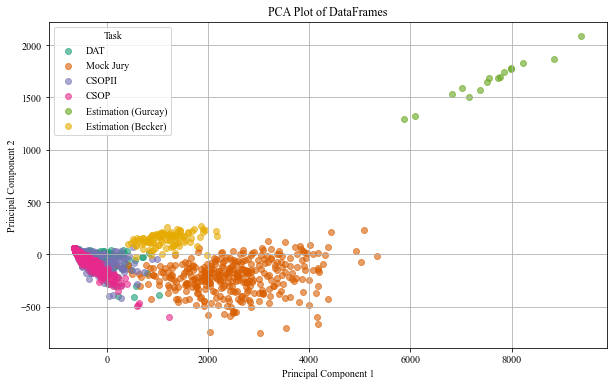

In [16]:
plot_pca_of_dataframes(juries_data, csop_data, csopII_data, dat_data, becker_data, gurcay_data, labels=dataset_labels)

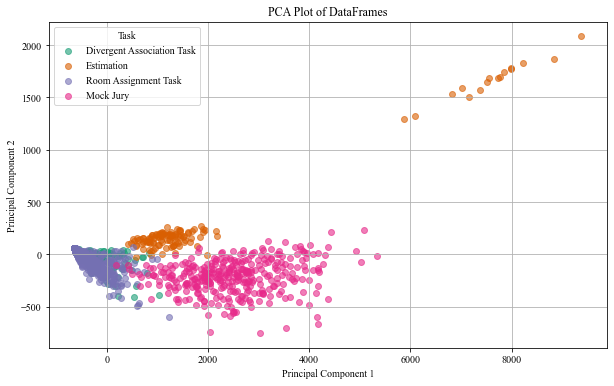

In [17]:
plot_pca_of_dataframes(juries_data, csop_blended_data, dat_data, estimation_blended_data, labels=labels)